In [3]:
import numpy as np
import pandas as pd
import pandapower as pp
import pandapower.networks as pn
import warnings
import dowhy
from dowhy import CausalModel
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
# Define function to check for N-1 contingency
def check_n_1_contingency(net):
    critical_elements = []
    
    # Backup original network
    original_net = net.deepcopy()
    
    # Test line outages
    for line in net.line.index:
        net_copy = original_net.deepcopy()
        net_copy.line.at[line, "in_service"] = False  # Remove one line
        try:
            pp.runpp(net_copy, algorithm="nr")
        except pp.powerflow.LoadflowNotConverged:
            critical_elements.append(f"Line {line} outage causes failure.")
            continue
        
        # Check for overloads
        if any(net_copy.res_line.loading_percent > 100):
            critical_elements.append(f"Line {line} outage causes overloads.")

    # Test generator outages
    for gen in net.gen.index:
        net_copy = original_net.deepcopy()
        net_copy.gen.at[gen, "in_service"] = False  # Remove one generator
        try:
            pp.runpp(net_copy, algorithm="nr")
        except pp.powerflow.LoadflowNotConverged:
            critical_elements.append(f"Generator {gen} outage causes failure.")
            continue

        # Check for voltage violations
        if any((net_copy.res_bus.vm_pu < 0.95) | (net_copy.res_bus.vm_pu > 1.05)):
            critical_elements.append(f"Generator {gen} outage causes voltage issues.")

    return critical_elements

In [5]:
# Load the IEEE 30-bus system
net = pn.case30()

# Function to reinforce the network based on contingency violations
def reinforce_network(net):
    original_net = net.deepcopy()
    
    # Identify problematic lines
    overloaded_lines = []
    for line in net.line.index:
        net_copy = original_net.deepcopy()
        net_copy.line.at[line, "in_service"] = False  # Simulate line outage
        try:
            pp.runpp(net_copy)
        except pp.powerflow.LoadflowNotConverged:
            overloaded_lines.append(line)
            continue
        if any(net_copy.res_line.loading_percent > 100):
            overloaded_lines.append(line)
    
    # Add parallel lines to overloaded lines
    for line in overloaded_lines:
        from_bus = net.line.loc[line, "from_bus"]
        to_bus = net.line.loc[line, "to_bus"]
        print(f"Adding parallel line between Bus {from_bus} and Bus {to_bus} to mitigate overload.")
        pp.create_line_from_parameters(net, from_bus=from_bus, to_bus=to_bus, 
                                       length_km=1.0, r_ohm_per_km=0.05, 
                                       x_ohm_per_km=0.1, c_nf_per_km=0, 
                                       max_i_ka=1.5)  # Higher capacity
    
    # Identify problematic generators
    problematic_gens = []
    for gen in net.gen.index:
        net_copy = original_net.deepcopy()
        net_copy.gen.at[gen, "in_service"] = False  # Simulate generator outage
        try:
            pp.runpp(net_copy)
        except pp.powerflow.LoadflowNotConverged:
            problematic_gens.append(gen)
            continue
        if any((net_copy.res_bus.vm_pu < 0.95) | (net_copy.res_bus.vm_pu > 1.05)):
            problematic_gens.append(gen)

    # Increase generator capacities to provide redundancy
    for gen in problematic_gens:
        net.gen.at[gen, "p_mw"] *= 1.2  # Increase power generation by 20%
        print(f"Increasing capacity of Generator {gen} to improve voltage stability.")

    return net

# Reinforce the network
net = reinforce_network(net)

# Run contingency check again
pp.runpp(net)
print("Reinforced system power flow successful.")

# Check if violations still exist
violations = check_n_1_contingency(net)
if violations:
    print("System still has issues under N-1 contingency.")
    for v in violations:
        print(v)
else:
    print("The 30-bus system satisfies the N-1 contingency criterion!")

Adding parallel line between Bus 0 and Bus 1 to mitigate overload.
Adding parallel line between Bus 0 and Bus 2 to mitigate overload.
Adding parallel line between Bus 1 and Bus 3 to mitigate overload.
Adding parallel line between Bus 2 and Bus 3 to mitigate overload.
Adding parallel line between Bus 1 and Bus 4 to mitigate overload.
Adding parallel line between Bus 1 and Bus 5 to mitigate overload.
Adding parallel line between Bus 3 and Bus 5 to mitigate overload.
Adding parallel line between Bus 4 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 7 to mitigate overload.
Adding parallel line between Bus 5 and Bus 8 to mitigate overload.
Adding parallel line between Bus 5 and Bus 9 to mitigate overload.
Adding parallel line between Bus 8 and Bus 10 to mitigate overload.
Adding parallel line between Bus 8 and Bus 9 to mitigate overload.
Adding parallel line between Bus 3 and Bus 11 to mitigate ove

In [6]:
# Inspect generators in the system
print(net.gen)
# Define PV buses
pv_buses = [1, 21, 26, 22, 12]

# Fixed means and standard deviations for each PV bus
pv_bus_means = [20.42496, 12.76560, 14.04216, 7.65936, 10.21248]
pv_bus_stds = [25.622111, 16.013819, 17.615201, 9.608292, 12.811055]

   name  bus    p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  73.164    1.0     NaN       -20.0        60.0      1.0  False   
1  None   21  25.908    1.0     NaN       -15.0        62.5      1.0  False   
2  None   26  32.292    1.0     NaN       -15.0        48.7      1.0  False   
3  None   22  19.200    1.0     NaN       -10.0        40.0      1.0  False   
4  None   12  37.000    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
1        True           0.0  None          True      50.0       0.0  
2        True           0.0  None          True      55.0       0.0  
3        True           0.0  None          True      30.0       0.0  
4        True           0.0  None          True      40.0       0.0  


## The causal effect of the PV bus output on grid reliability
The objective of this work is to investigate the causal relationships and causal effects between different
electrical components of the power system and the reliability performance of the system.<br>
These scenarios were analyzed to explore the power system’s reliability performance and assess the impact of variable
fluctuations with different components of the power system on the grid reliability.

In [7]:
# Deactive specific generators(bus 21 22) # Make the solar-based generators more significant
net.gen.drop(net.gen[net.gen['bus'].isin([21,22])].index, inplace=True)

# Verify the remaining generators
print(net.gen)

   name  bus    p_mw  vm_pu  sn_mva  min_q_mvar  max_q_mvar  scaling  slack  \
0  None    1  73.164    1.0     NaN       -20.0        60.0      1.0  False   
2  None   26  32.292    1.0     NaN       -15.0        48.7      1.0  False   
4  None   12  37.000    1.0     NaN       -15.0        44.7      1.0  False   

   in_service  slack_weight  type  controllable  max_p_mw  min_p_mw  
0        True           0.0  None          True      80.0       0.0  
2        True           0.0  None          True      55.0       0.0  
4        True           0.0  None          True      40.0       0.0  


In [8]:
installed_capacities =[80, 50, 55, 30, 40]
# Create Static Generators (sgen) for the PV buses
for bus, installed_capacity in zip(pv_buses, installed_capacities):
    pp.create_sgen(net, bus, p_mw=0, max_p_mw=installed_capacity, name=f"PV_bus_{bus}")
    # Verify static generator table
print(net.sgen)

        name  bus  p_mw  q_mvar  sn_mva  scaling  in_service type  \
0   PV_bus_1    1   0.0     0.0     NaN      1.0        True  wye   
1  PV_bus_21   21   0.0     0.0     NaN      1.0        True  wye   
2  PV_bus_26   26   0.0     0.0     NaN      1.0        True  wye   
3  PV_bus_22   22   0.0     0.0     NaN      1.0        True  wye   
4  PV_bus_12   12   0.0     0.0     NaN      1.0        True  wye   

   current_source  max_p_mw  
0            True      80.0  
1            True      50.0  
2            True      55.0  
3            True      30.0  
4            True      40.0  


In [9]:
n_scenarios = 100  # Number of scenarios
n_runs_per_scenario = 500  # Monte Carlo runs per scenario
scenario_results = []
# Acceptable variation (Assume the variation with the original mean and std)
mean_variation = 1
std_variation = 1

In [10]:
# Iterate Over Scenarios
for scenario in range(n_scenarios):
    scenario_lolps = []  # Store LOLP for each run in this scenario

In [11]:
# Generate scenarios
for scenario in range(n_scenarios):
    # Adjust mean and std for this scenario
    print(f"Running Scenario {scenario + 1}/{n_scenarios}")
    lolp_count = 0  # To count the number of load losses
    scenario_means = [mean * (1 + np.random.uniform(-mean_variation, mean_variation)) for mean in pv_bus_means]
    scenario_stds = [std * (1 + np.random.uniform(-std_variation, std_variation)) for std in pv_bus_stds]
    
    scenario_lolps = []  # Store LOLP for each run in this scenario
    total_solar_generation = []
    total_reactive_power = []
    voltage_deviations = []
    for run in range(n_runs_per_scenario):
        # Sample PV outputs from normal distribution
        pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(scenario_means, scenario_stds)]
        
        # Update PV generation in the network
        for i, bus in enumerate(pv_buses):
            net.sgen.loc[net.sgen['bus'] == bus, 'p_mw'] = pv_outputs[i]
        
        try:
            # Run power flow
            pp.runpp(net)
            
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_solar_generation.append(net.res_sgen['p_mw'].sum())
            total_reactive_power.append(net.res_bus['q_mvar'].sum())
            voltage_deviation = np.mean(abs(net.res_bus['vm_pu'] - 1.0))
            voltage_deviations.append(voltage_deviation)
            
            # Calculate voltage deviation from 1.0 p.u.
            voltage_dev = abs(net.res_bus['vm_pu'] - 1).mean()
            voltage_deviations.append(voltage_dev)
            
            # Calculate LOLP
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_load = net.load['p_mw'].sum()
            lolp = 1 if total_generation < total_load else 0  # Load loss if generation < load
            scenario_lolps.append(lolp)
        except pp.LoadflowNotConverged:
            print(f"Power flow did not converge for scenario {scenario}, run {run}.")
            continue
    
    # Calculate average LOLP for this scenario
    avg_lolp = np.mean(scenario_lolps) if scenario_lolps else None
    print(f"Scenario {scenario + 1}: Average LOLP = {avg_lolp}")
    avg_solar_generation = np.mean(total_solar_generation)
    avg_reactive_power = np.mean(total_reactive_power)
    avg_voltage_deviation = np.mean(voltage_deviations)
    
    # Calculate LOLP for this scenario
    lolp = lolp_count / n_runs_per_scenario
    scenario_results.append({
        'Scenario': scenario + 1,
        'PV1 Mean Output': scenario_means[0],
        'PV1 Std Output': scenario_stds[0],
        'PV2 Mean Output': scenario_means[1],
        'PV2 Std Output': scenario_stds[1],
        'PV3 Mean Output': scenario_means[2],
        'PV3 Std Output': scenario_stds[2],
        'PV4 Mean Output': scenario_means[3],
        'PV4 Std Output': scenario_stds[3],
        'PV5 Mean Output': scenario_means[4],
        'PV5 Std Output': scenario_stds[4],
        'Total Solar Generation': avg_solar_generation,
        'Total Reactive Power': avg_reactive_power,
        'Voltage Deviation': avg_voltage_deviation,
        'LOLP': avg_lolp
    })

# Save results to a DataFrame
df_scenario_results = pd.DataFrame(scenario_results)
df_scenario_results.to_excel("100_scenarios_drop2_results.xlsx", index=False)
print("Scenario results saved to '100_scenarios_drop2_results.xlsx'.")

Running Scenario 1/100
Scenario 1: Average LOLP = 0.3
Running Scenario 2/100
Scenario 2: Average LOLP = 0.472
Running Scenario 3/100
Scenario 3: Average LOLP = 0.11
Running Scenario 4/100
Scenario 4: Average LOLP = 0.098
Running Scenario 5/100
Scenario 5: Average LOLP = 0.146
Running Scenario 6/100
Scenario 6: Average LOLP = 0.23
Running Scenario 7/100
Scenario 7: Average LOLP = 0.088
Running Scenario 8/100
Scenario 8: Average LOLP = 0.404
Running Scenario 9/100
Scenario 9: Average LOLP = 0.268
Running Scenario 10/100
Scenario 10: Average LOLP = 0.068
Running Scenario 11/100
Scenario 11: Average LOLP = 0.092
Running Scenario 12/100
Scenario 12: Average LOLP = 0.02
Running Scenario 13/100
Scenario 13: Average LOLP = 0.154
Running Scenario 14/100
Scenario 14: Average LOLP = 0.164
Running Scenario 15/100
Scenario 15: Average LOLP = 0.0
Running Scenario 16/100
Scenario 16: Average LOLP = 0.168
Running Scenario 17/100
Scenario 17: Average LOLP = 0.128
Running Scenario 18/100
Scenario 18: Av

In [12]:
data = pd.read_excel('100_scenarios_drop2_results.xlsx')
# View data structure
print(data.head())

   Scenario  PV1 Mean Output  PV1 Std Output  PV2 Mean Output  PV2 Std Output  \
0         1        16.844953       28.141423        11.390495       13.479572   
1         2         0.856277       13.997429         5.219793       18.447938   
2         3         8.560298       27.378457        21.391701       10.828742   
3         4        39.345388       14.501897        10.468314       24.729575   
4         5        22.817762       51.108395        24.069736       19.587527   

   PV3 Mean Output  PV3 Std Output  PV4 Mean Output  PV4 Std Output  \
0         4.591323       22.098696         8.403046        8.156419   
1         6.055406       20.599455        11.173679       15.425659   
2        16.518892       33.279260        12.048832       10.219922   
3         3.837488       27.483939         4.530173        9.630663   
4         7.431081       30.661130         4.261820        0.593578   

   PV5 Mean Output  PV5 Std Output  Total Solar Generation  \
0         6.700757      

Analyzing causal effect of PV1 Mean Output on LOLP:


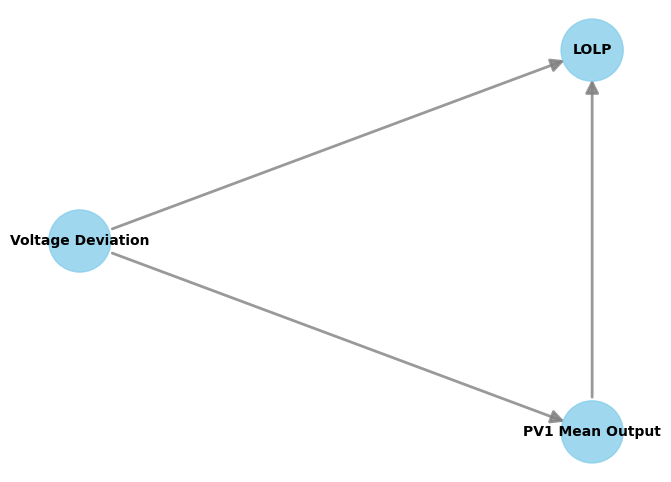

Causal Effect of PV1 Mean Output on LOLP: -0.0061629546589228035


Analyzing causal effect of PV2 Mean Output on LOLP:


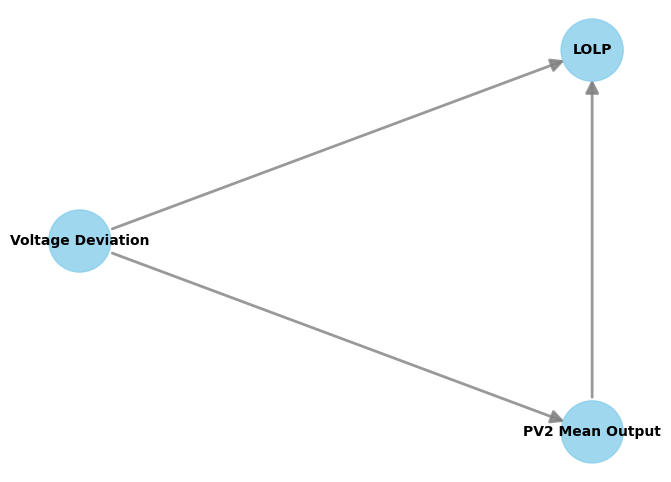

Causal Effect of PV2 Mean Output on LOLP: -0.0022612997861532202


Analyzing causal effect of PV3 Mean Output on LOLP:


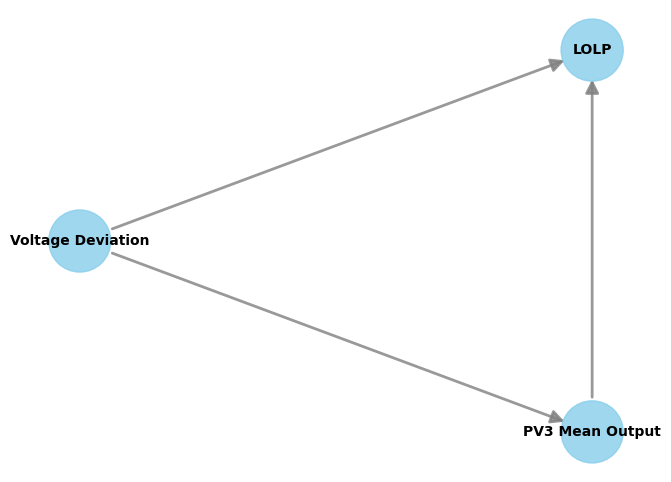

Causal Effect of PV3 Mean Output on LOLP: -0.006203712742255618


Analyzing causal effect of PV4 Mean Output on LOLP:


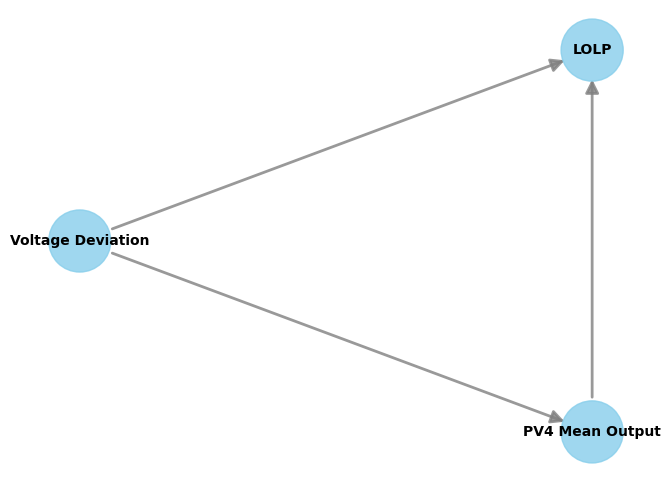

Causal Effect of PV4 Mean Output on LOLP: 0.004102969154264224


Analyzing causal effect of PV5 Mean Output on LOLP:


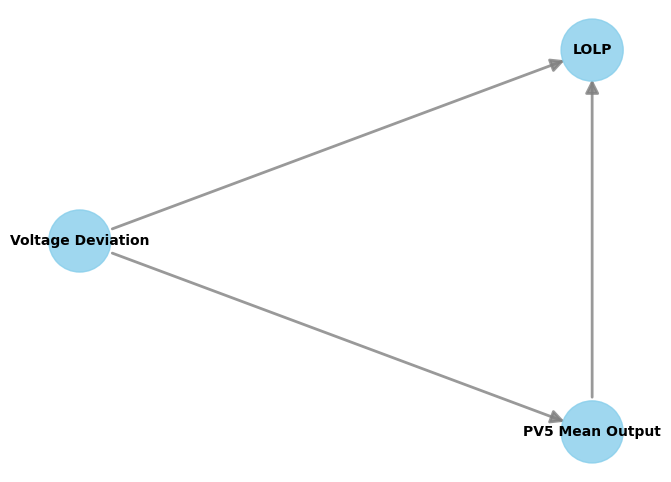

Causal Effect of PV5 Mean Output on LOLP: -0.008459911168470058


Analyzing causal effect of Total Solar Generation on LOLP:


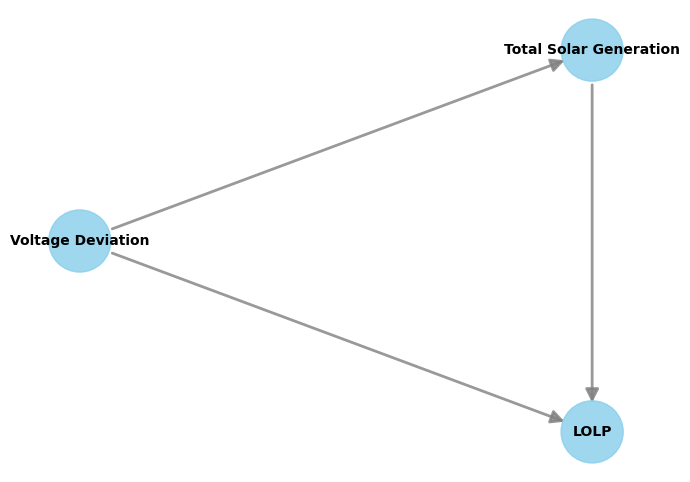

Causal Effect of Total Solar Generation on LOLP: -0.00753243555642491




In [13]:
# Iterate over each PV bus output as the treatment variable
pv_buses = ['PV1 Mean Output', 'PV2 Mean Output', 'PV3 Mean Output', 'PV4 Mean Output', 'PV5 Mean Output','Total Solar Generation']

for pv_bus in pv_buses:
    print(f"Analyzing causal effect of {pv_bus} on LOLP:")
    # Define the causal model
    model = CausalModel(
    data=data,
    treatment=pv_bus,  # Treatments
    outcome='LOLP',  # Reliability indicator
    common_causes=['Voltage Deviation'] 
    )# Visualize the DAG
    model.view_model()

# Identify and estimate the causal effect
    identified_estimand = model.identify_effect()
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"
    )
    
    print(f"Causal Effect of {pv_bus} on LOLP: {causal_estimate.value}")
    print("\n")

## The causal effect of Reactive power capacity on grid Reliability

In [14]:
# Load and the 30-bus reinforce network
net = pn.case30()
net = reinforce_network(net)

# Define PV buses
pv_buses = [1, 21, 26, 22, 12]

# Fixed means and standard deviations for injected power
pv_bus_means = [20.42496, 12.76560, 14.04216, 7.65936, 10.21248]
pv_bus_stds = [25.622111, 16.013819, 17.615201, 9.608292, 12.811055]

# Define base reactive power capacities
base_min_q = [-20.0, -15.0, -15.0, -10.0, -15.0]
base_max_q = [60.0, 62.5, 48.7, 40.0, 44.7]

# Reactive power variability (normal distribution parameters)
min_q_mean_variation = 0.1  # ±10% of base min_q
max_q_mean_variation = 0.1  # ±10% of base max_q
std_dev_factor = 0.05  # Std dev as a fraction of mean

Adding parallel line between Bus 0 and Bus 1 to mitigate overload.
Adding parallel line between Bus 0 and Bus 2 to mitigate overload.
Adding parallel line between Bus 1 and Bus 3 to mitigate overload.
Adding parallel line between Bus 2 and Bus 3 to mitigate overload.
Adding parallel line between Bus 1 and Bus 4 to mitigate overload.
Adding parallel line between Bus 1 and Bus 5 to mitigate overload.
Adding parallel line between Bus 3 and Bus 5 to mitigate overload.
Adding parallel line between Bus 4 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 7 to mitigate overload.
Adding parallel line between Bus 5 and Bus 8 to mitigate overload.
Adding parallel line between Bus 5 and Bus 9 to mitigate overload.
Adding parallel line between Bus 8 and Bus 10 to mitigate overload.
Adding parallel line between Bus 8 and Bus 9 to mitigate overload.
Adding parallel line between Bus 3 and Bus 11 to mitigate ove

In [15]:
# Number of scenarios and Monte Carlo runs
n_scenarios = 100
n_runs_per_scenario = 500
# Results storage
scenario_results = []

In [16]:
# Generate scenarios
for scenario in range(n_scenarios):
    print(f"Running Scenario {scenario + 1}/{n_scenarios}")
    lolp_count = 0
    total_solar_generation = []
    total_reactive_power = []
    voltage_deviations = []
    
    # Adjust reactive power capacities for this scenario
    scenario_min_q = [np.random.normal(min_q * (1 + np.random.uniform(-min_q_mean_variation, min_q_mean_variation)), 
                                       abs(min_q * std_dev_factor)) for min_q in base_min_q]
    scenario_max_q = [np.random.normal(max_q * (1 + np.random.uniform(-max_q_mean_variation, max_q_mean_variation)), 
                                       abs(max_q * std_dev_factor)) for max_q in base_max_q]
    
    for run in range(n_runs_per_scenario):
        # Sample PV outputs from the normal distribution
        pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(pv_bus_means, pv_bus_stds)]
       # Update PV generation in the network
        for i, bus in enumerate(pv_buses):
            if bus in net.sgen['bus'].values:
                net.sgen.loc[net.sgen['bus'] == bus, 'p_mw'] = pv_outputs[i]
            else:
                pp.create_sgen(net, bus, p_mw=pv_outputs[i], name=f"PV_bus_{bus}")
        
        # Update reactive power capacities
        for i, bus in enumerate(pv_buses):
            net.gen.loc[net.gen['bus'] == bus, 'min_q_mvar'] = scenario_min_q[i]
            net.gen.loc[net.gen['bus'] == bus, 'max_q_mvar'] = scenario_max_q[i]
        
        try:
            # Run power flow
            pp.runpp(net)
            
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_solar_generation.append(net.res_sgen['p_mw'].sum())
            total_reactive_power.append(net.res_bus['q_mvar'].sum())
            voltage_deviation = np.mean(abs(net.res_bus['vm_pu'] - 1.0))
            voltage_deviations.append(voltage_deviation)
            
            # Calculate LOLP
            total_load = net.load['p_mw'].sum()
            if total_generation < total_load:
                lolp_count += 1
        except pp.LoadflowNotConverged:
            print(f"Loadflow did not converge for Scenario {scenario + 1}, Run {run + 1}.")
            continue
    # Calculate scenario metrics
    avg_lolp = lolp_count / n_runs_per_scenario
    print(f"Scenario {scenario + 1}: Average LOLP = {avg_lolp}")
    avg_solar_generation = np.mean(total_solar_generation)
    avg_reactive_power = np.mean(total_reactive_power)
    avg_voltage_deviation = np.mean(voltage_deviations)
    
    # Record scenario results
    scenario_results.append({
        'Scenario': scenario + 1,
        'Min Q (PV1)': scenario_min_q[0],
        'Max Q (PV1)': scenario_max_q[0],
        'Min Q (PV2)': scenario_min_q[1],
        'Max Q (PV2)': scenario_max_q[1],
        'Min Q (PV3)': scenario_min_q[2],
        'Max Q (PV3)': scenario_max_q[2],
        'Min Q (PV4)': scenario_min_q[3],
        'Max Q (PV4)': scenario_max_q[3],
        'Min Q (PV5)': scenario_min_q[4],
        'Max Q (PV5)': scenario_max_q[4],
        'Total Solar Generation': avg_solar_generation,
        'Total Reactive Power': avg_reactive_power,
        'Voltage Deviation': avg_voltage_deviation,
        'LOLP': avg_lolp
    })

# Save results to a DataFrame
df_scenario_results = pd.DataFrame(scenario_results)
df_scenario_results.to_excel("reactive_power_scenarios.xlsx", index=False)
print("Scenario results saved to 'reactive_power_scenarios.xlsx'.")

Running Scenario 1/100
Scenario 1: Average LOLP = 0.0
Running Scenario 2/100
Scenario 2: Average LOLP = 0.0
Running Scenario 3/100
Scenario 3: Average LOLP = 0.0
Running Scenario 4/100
Scenario 4: Average LOLP = 0.0
Running Scenario 5/100
Scenario 5: Average LOLP = 0.0
Running Scenario 6/100
Scenario 6: Average LOLP = 0.0
Running Scenario 7/100
Scenario 7: Average LOLP = 0.0
Running Scenario 8/100
Scenario 8: Average LOLP = 0.002
Running Scenario 9/100
Scenario 9: Average LOLP = 0.0
Running Scenario 10/100
Scenario 10: Average LOLP = 0.002
Running Scenario 11/100
Scenario 11: Average LOLP = 0.004
Running Scenario 12/100
Scenario 12: Average LOLP = 0.0
Running Scenario 13/100
Scenario 13: Average LOLP = 0.0
Running Scenario 14/100
Scenario 14: Average LOLP = 0.002
Running Scenario 15/100
Scenario 15: Average LOLP = 0.002
Running Scenario 16/100
Scenario 16: Average LOLP = 0.002
Running Scenario 17/100
Scenario 17: Average LOLP = 0.0
Running Scenario 18/100
Scenario 18: Average LOLP = 0.

In [17]:
data = pd.read_excel("reactive_power_scenarios.xlsx")
# View data structure
print(data.head())

   Scenario  Min Q (PV1)  Max Q (PV1)  Min Q (PV2)  Max Q (PV2)  Min Q (PV3)  \
0         1   -22.745586    67.144673   -16.438052    65.120060   -16.965417   
1         2   -22.378693    54.159383   -15.012786    62.894263   -17.789015   
2         3   -19.472359    54.934863   -14.403430    71.705231   -14.031661   
3         4   -18.740268    52.107465   -15.484081    64.197530   -15.684914   
4         5   -20.335543    62.657443   -16.535398    59.265419   -17.361547   

   Max Q (PV3)  Min Q (PV4)  Max Q (PV4)  Min Q (PV5)  Max Q (PV5)  \
0    50.395849   -11.381824    43.038744   -14.204842    45.270404   
1    45.607495   -10.412692    36.540996   -14.419915    45.101787   
2    49.950512    -8.421820    39.859966   -13.545472    43.728005   
3    42.415762   -10.470029    40.464326   -13.275430    44.696955   
4    42.744790    -9.541057    38.253220   -15.834769    42.537230   

   Total Solar Generation  Total Reactive Power  Voltage Deviation  LOLP  
0               76.1044

Analyzing causal effect for treatment: Min Q (PV1)


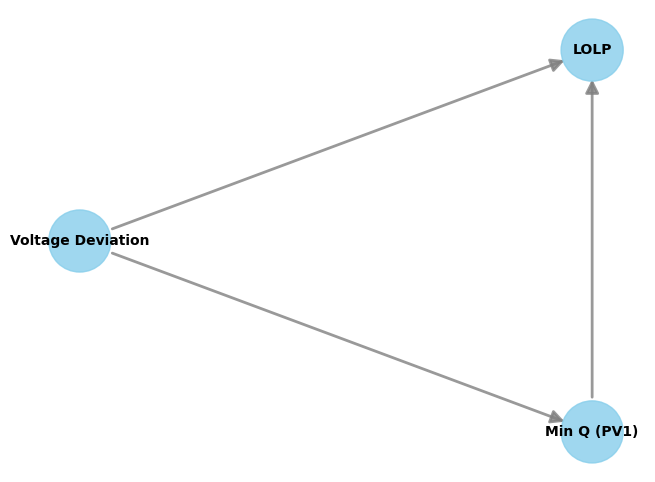

Causal Effect Estimate for Min Q (PV1): 6.735820872449949e-05
--------------------------------------------------
Analyzing causal effect for treatment: Max Q (PV1)


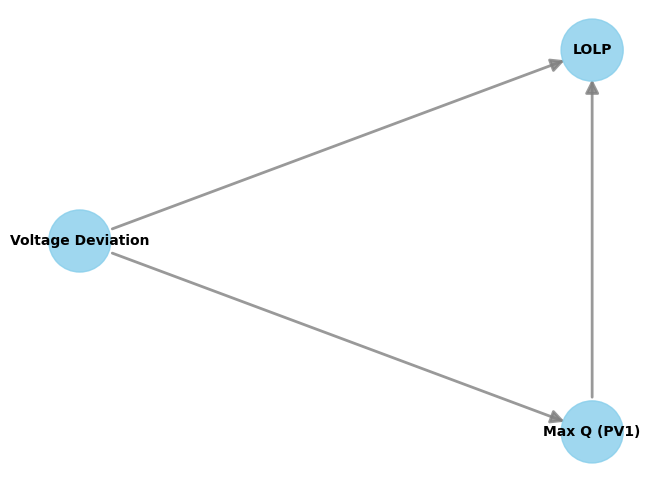

Causal Effect Estimate for Max Q (PV1): 3.836645251453774e-05
--------------------------------------------------
Analyzing causal effect for treatment: Min Q (PV2)


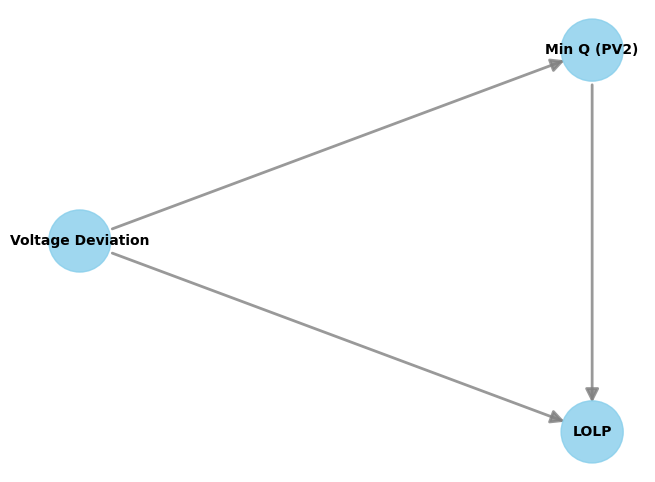

Causal Effect Estimate for Min Q (PV2): -0.00015071824370949116
--------------------------------------------------
Analyzing causal effect for treatment: Max Q (PV2)


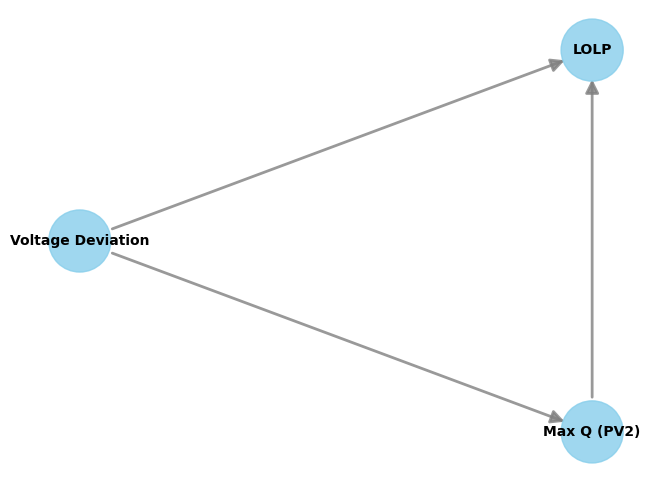

Causal Effect Estimate for Max Q (PV2): 2.986501506541117e-06
--------------------------------------------------
Analyzing causal effect for treatment: Min Q (PV3)


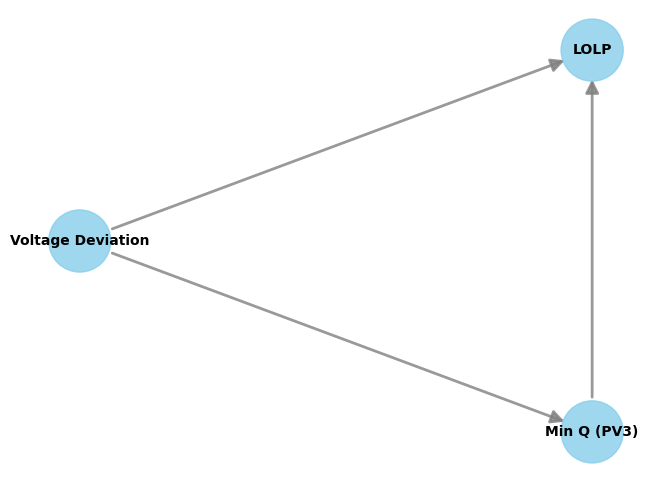

Causal Effect Estimate for Min Q (PV3): 0.00014238766398833036
--------------------------------------------------
Analyzing causal effect for treatment: Max Q (PV3)


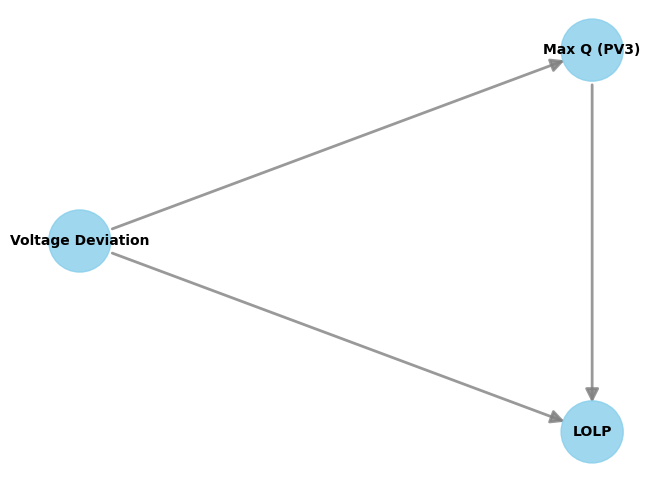

Causal Effect Estimate for Max Q (PV3): -2.4890485292416997e-05
--------------------------------------------------
Analyzing causal effect for treatment: Min Q (PV4)


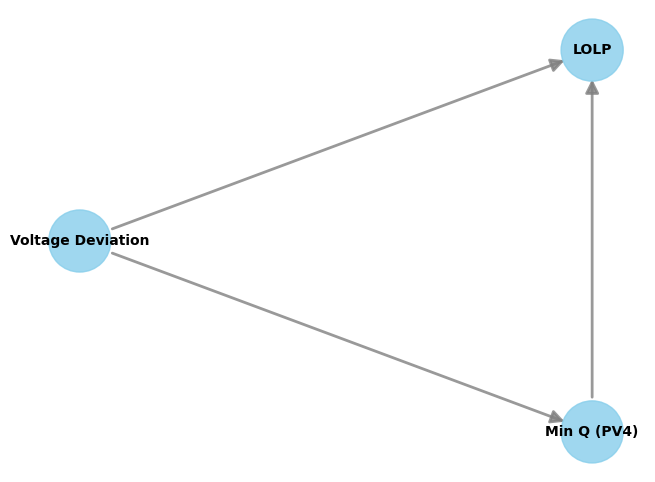

Causal Effect Estimate for Min Q (PV4): 0.00011575638153615841
--------------------------------------------------
Analyzing causal effect for treatment: Max Q (PV4)


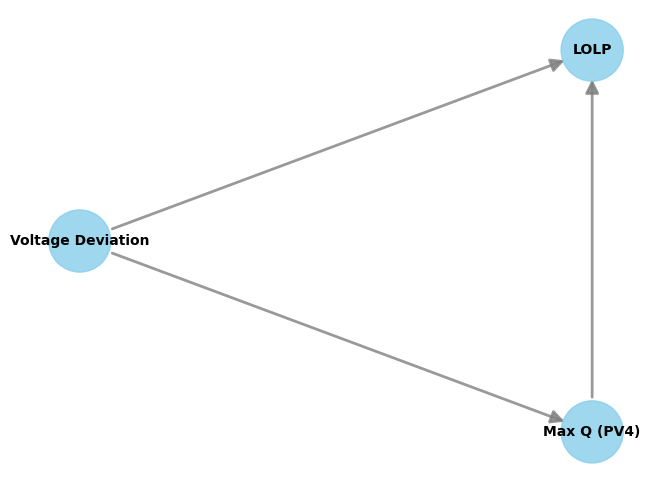

Causal Effect Estimate for Max Q (PV4): -5.1884934215706835e-06
--------------------------------------------------
Analyzing causal effect for treatment: Min Q (PV5)


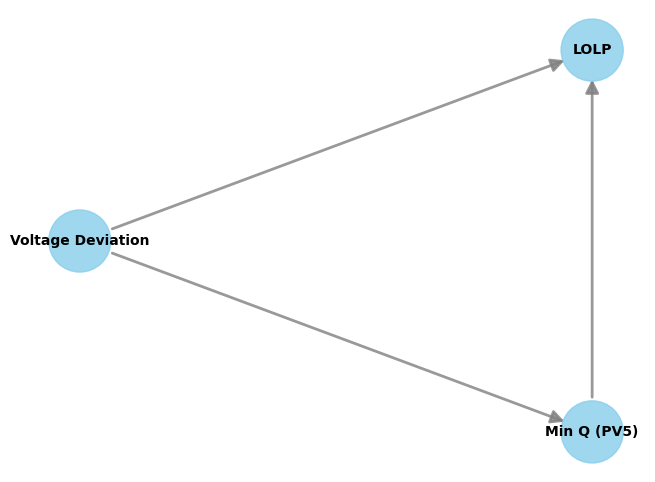

Causal Effect Estimate for Min Q (PV5): -0.00010742448951006622
--------------------------------------------------
Analyzing causal effect for treatment: Max Q (PV5)


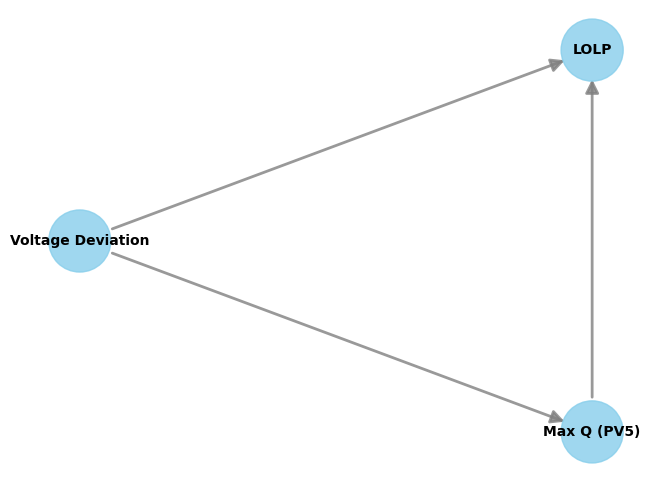

Causal Effect Estimate for Max Q (PV5): 1.574405652249311e-05
--------------------------------------------------


In [18]:
pv_buses = ['Min Q (PV1)', 'Max Q (PV1)', 'Min Q (PV2)', 'Max Q (PV2)',
            'Min Q (PV3)', 'Max Q (PV3)', 'Min Q (PV4)', 'Max Q (PV4)',
            'Min Q (PV5)', 'Max Q (PV5)']

# Loop through each PV bus feature
for pv_bus in pv_buses:
    print(f"Analyzing causal effect for treatment: {pv_bus}")
    
    # Create the CausalModel
    model = CausalModel(
        data=data,
        treatment=pv_bus,  # Reactive power capacity of the current PV bus
        outcome='LOLP',  # Outcome variable
        common_causes=['Voltage Deviation']  # Known confounders
    )
    
    # Visualize the DAG
    model.view_model()  #  generate the DAG 
    
    # Identify the causal effect
    identified_estimand = model.identify_effect()
    #print("Identified Estimand:", identified_estimand)
    
    # Estimate the causal effect
    causal_estimate = model.estimate_effect(
        identified_estimand,
        method_name="backdoor.linear_regression"  # Suitable for continuous treatments
    )
    
    # Print the causal effect estimate
    print(f"Causal Effect Estimate for {pv_bus}: {causal_estimate.value}")
    print("-" * 50)


## Exploring Impedance Distance and Grid Reliability 
The causal effect of variations in impedance distance (transmission line characteristics) on the reliability of the power grid.

In [19]:
# Load and the 30-bus reinforce network
net = pn.case30()
net = reinforce_network(net)

Adding parallel line between Bus 0 and Bus 1 to mitigate overload.
Adding parallel line between Bus 0 and Bus 2 to mitigate overload.
Adding parallel line between Bus 1 and Bus 3 to mitigate overload.
Adding parallel line between Bus 2 and Bus 3 to mitigate overload.
Adding parallel line between Bus 1 and Bus 4 to mitigate overload.
Adding parallel line between Bus 1 and Bus 5 to mitigate overload.
Adding parallel line between Bus 3 and Bus 5 to mitigate overload.
Adding parallel line between Bus 4 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 6 to mitigate overload.
Adding parallel line between Bus 5 and Bus 7 to mitigate overload.
Adding parallel line between Bus 5 and Bus 8 to mitigate overload.
Adding parallel line between Bus 5 and Bus 9 to mitigate overload.
Adding parallel line between Bus 8 and Bus 10 to mitigate overload.
Adding parallel line between Bus 8 and Bus 9 to mitigate overload.
Adding parallel line between Bus 3 and Bus 11 to mitigate ove

In [20]:
# Define PV buses
pv_buses = [1, 21, 26, 22, 12]

# Fixed means and standard deviations for injected power
pv_bus_means = [20.42496, 12.76560, 14.04216, 7.65936, 10.21248]
pv_bus_stds = [25.622111, 16.013819, 17.615201, 9.608292, 12.811055]

# Inspect the transmission line characteristics #Resistance Reactance Capacitance per kilometer per kilometer
print(net.line[['from_bus', 'to_bus', 'length_km', 'r_ohm_per_km', 'x_ohm_per_km', 'c_nf_per_km']])

    from_bus  to_bus  length_km  r_ohm_per_km  x_ohm_per_km  c_nf_per_km
0          0       1        1.0        3.6450       10.9350   436.639076
1          0       2        1.0        9.1125       34.6275   291.092717
2          1       3        1.0       10.9350       30.9825   291.092717
3          2       3        1.0        1.8225        7.2900     0.000000
4          1       4        1.0        9.1125       36.4500   291.092717
5          1       5        1.0       10.9350       32.8050   291.092717
6          3       5        1.0        1.8225        7.2900     0.000000
7          4       6        1.0        9.1125       21.8700   145.546359
8          5       6        1.0        5.4675       14.5800   145.546359
9          5       7        1.0        1.8225        7.2900     0.000000
10         5       8        1.0        0.0000       38.2725     0.000000
11         5       9        1.0        0.0000      102.0600     0.000000
12         8      10        1.0        0.0000      

In [21]:
n_topologies = 100  # Number of grid topologies
n_runs_per_scenario = 500
# Create a list to store results
topology_results = []

# Function to calculate impedance distance
def calculate_impedance_distance(net):
    return np.sum(np.sqrt(net.line['r_ohm_per_km']**2 + net.line['x_ohm_per_km']**2) * net.line['length_km'])

# Generate different topologies by varying line impedances
for topology in range(n_topologies):
    print(f"Running Topology {topology + 1}/{n_topologies}")
    lolp_count = 0
    voltage_deviations = []
    total_generations = []
    
    # Introduce random variations in line impedances
    net.line['r_ohm_per_km'] = net.line['r_ohm_per_km'] * (1 + np.random.uniform(-0.2, 0.2, size=len(net.line)))
    net.line['x_ohm_per_km'] = net.line['x_ohm_per_km'] * (1 + np.random.uniform(-0.2, 0.2, size=len(net.line)))
    
    # Calculate the impedance distance for this topology
    impedance_distance = calculate_impedance_distance(net)
    
    # Run stochastic simulations to calculate reliability metrics    
    for run in range(n_runs_per_scenario):  # Monte Carlo runs per topology
        try:
            # Sample PV outputs from the normal distribution
            pv_outputs = [max(0, np.random.normal(mean, std)) for mean, std in zip(pv_bus_means, pv_bus_stds)]
            # Update PV generation in the network
            for i, bus in enumerate(pv_buses):
                if bus in net.sgen['bus'].values:
                    net.sgen.loc[net.sgen['bus'] == bus, 'p_mw'] = pv_outputs[i]
                else:
                    pp.create_sgen(net, bus, p_mw=pv_outputs[i], name=f"PV_bus_{bus}")
                    
            # Run power flow
            pp.runpp(net)
            
            # Calculate metrics
            total_generation = net.res_sgen['p_mw'].sum() + net.res_gen['p_mw'].sum()
            total_load = net.load['p_mw'].sum()
            
            # Calculate LOLP
            if total_generation < total_load:
                lolp_count += 1
            
            # Voltage deviation
            voltage_deviation = np.mean(abs(net.res_bus['vm_pu'] - 1.0))
            voltage_deviations.append(voltage_deviation)
            total_generations.append(total_generation)
        
        except pp.LoadflowNotConverged:
            print(f"Loadflow did not converge for Topology {topology + 1}, Run {run + 1}.")
            continue
    
    # Average metrics for this topology
    avg_lolp = lolp_count / n_runs_per_scenario
    print(f"Scenario {topology + 1}: Average LOLP = {avg_lolp}")
    avg_voltage_deviation = np.mean(voltage_deviations)
    avg_total_generation = np.mean(total_generations)
    mean_impedance_distance = impedance_distance
    
    # Store results
    topology_results.append({
        'Topology': topology + 1,
        'Average LOLP': avg_lolp,
        'Impedance Distance': mean_impedance_distance,
        'Voltage Deviation': avg_voltage_deviation,
        'Average Total Generation': avg_total_generation
    })

# Save results to an Excel file
df_topology_results = pd.DataFrame(topology_results)
df_topology_results.to_excel("topology_reliability_results.xlsx", index=False)
print("Topology results saved to 'topology_reliability_results.xlsx'.")

Running Topology 1/100
Scenario 1: Average LOLP = 0.0
Running Topology 2/100
Scenario 2: Average LOLP = 0.0
Running Topology 3/100
Scenario 3: Average LOLP = 0.0
Running Topology 4/100
Scenario 4: Average LOLP = 0.004
Running Topology 5/100
Scenario 5: Average LOLP = 0.0
Running Topology 6/100
Scenario 6: Average LOLP = 0.0
Running Topology 7/100
Scenario 7: Average LOLP = 0.0
Running Topology 8/100
Scenario 8: Average LOLP = 0.002
Running Topology 9/100
Scenario 9: Average LOLP = 0.0
Running Topology 10/100
Scenario 10: Average LOLP = 0.0
Running Topology 11/100
Scenario 11: Average LOLP = 0.0
Running Topology 12/100
Scenario 12: Average LOLP = 0.002
Running Topology 13/100
Scenario 13: Average LOLP = 0.0
Running Topology 14/100
Scenario 14: Average LOLP = 0.002
Running Topology 15/100
Scenario 15: Average LOLP = 0.0
Running Topology 16/100
Scenario 16: Average LOLP = 0.0
Running Topology 17/100
Scenario 17: Average LOLP = 0.0
Running Topology 18/100
Scenario 18: Average LOLP = 0.0
Ru

In [22]:
# Load the results
data = pd.read_excel("topology_reliability_results.xlsx")
# View data structure
print(data.head())

   Topology  Average LOLP  Impedance Distance  Voltage Deviation  \
0         1         0.000         1656.281156           0.000074   
1         2         0.000         1612.390606           0.000074   
2         3         0.000         1638.516694           0.000070   
3         4         0.004         1646.804695           0.000068   
4         5         0.000         1680.696849           0.000066   

   Average Total Generation  
0                261.320672  
1                259.757878  
2                263.401709  
3                262.574791  
4                261.270358  


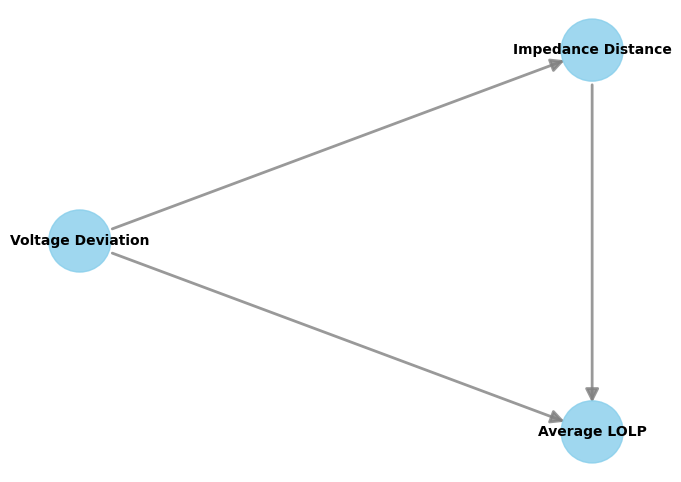

Causal Effect Estimate: 2.5121713801532115e-06


In [23]:
# Define the causal model
model = CausalModel(
    data=data,
    treatment="Impedance Distance",  # Proxy for impedance distance
    outcome="Average LOLP",
    common_causes=["Voltage Deviation"]  # Confounders
)
    # Visualize the DAG
model.view_model()  #  generate the DAG 
# Identify and estimate the causal effect
identified_estimand = model.identify_effect()
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("Causal Effect Estimate:", causal_estimate.value)